In [1]:
from wrapper.single_turbo_wrapper import STGraphWrapper

from CybORG import CybORG
from CybORG.Simulator.Scenarios.EnterpriseScenarioGenerator import EnterpriseScenarioGenerator
from CybORG.Agents import SleepAgent, EnterpriseGreenAgent, FiniteStateRedAgent
from collections import deque
import random
import numpy as np
from submission import Submission
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import traceback
from joblib import Parallel, delayed
import os
import torch.multiprocessing as mp
from types import SimpleNamespace

In [2]:
class DQN(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, output_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

In [3]:
class DQNAgent:
    def __init__(self, agent, input_dim, hidden_dim_1, output_dim, lr, memory_capacity):
        self.device = device
        self.policy_net = DQN(input_dim, hidden_dim_1, output_dim).to(self.device)
        self.target_net = DQN(input_dim, hidden_dim_1, output_dim).to(self.device)
        self.name = agent
        print(f"agent {self.name} initiation")
        try:
            # raise Exception
            self.policy_net.load_state_dict(torch.load(f"dqn_Single_Turbo_policy_{agent}_net_Jul21.pth"))
            self.target_net.load_state_dict(torch.load(f"dqn_Single_Turbo_target_{agent}_net_Jul21.pth"))
            self.policy_net.train()
            self.target_net.eval()
            print("model loaded successfully")
        except Exception:
            # traceback.print_exc()
            print("model not loaded")
            self.target_net.load_state_dict(self.policy_net.state_dict())
            self.target_net.eval()

        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=lr)
        # self.criterion = nn.MSELoss()
        self.criterion = nn.SmoothL1Loss()
        self.replay_buffer = deque(maxlen=memory_capacity)
        
# """ Does this need to be edited? """
    def select_action(self, state, epsilon):
        if state[-1] == 0: #since this action is None
            return 0
        else:
            print(state[-1])
        if random.random() < epsilon:
            return random.randint(0, 6)  # 4 + 2 + 1 actions
        with torch.no_grad():
            q = self.policy_net(state.to(self.device))
            return q.argmax().item()
            
    def store_transition(self, *transition): 
        (state, deception, reward, next_state, done) = transition
        i = f"blue_agent_{self.name}"
        agent_transition = (state[self.name], deception[self.name], reward[i], next_state[self.name], done[self.name])
        self.replay_buffer.append(agent_transition)

    def sample_batch(self, batch_size):
        return random.sample(self.replay_buffer, batch_size)

    def update(self, batch, gamma):
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.cat(states).to(self.device)
        next_states = torch.cat(next_states).to(self.device)
        actions = torch.tensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        q_values = self.policy_net(states).gather(1, actions)
        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target = -rewards + gamma * next_q * (1-dones) 

        loss = self.criterion(q_values, target)
        # loss = nn.SmoothL1Loss()(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # print(f"loss is ({loss})")
        return loss.item()

In [4]:
# 0. Initializing with parallelization parameters
HYPER_PARAMS = SimpleNamespace(
    agent_num = 5,
    episode_length = 500,
    episode_num = 2000,
    workers = 1,  # Number of parallel environments
    batch_size = 300,
    memory_capacity = 30000,
    lr = 0.0001,
    tau = 0.0001,
    target_update_freq = 5,
    epsilon = 0.1,
    gamma = 0.99
)

MAX_THREADS = min(os.cpu_count(), 30)  # Limit to CPU count or 20 (default was 12)
torch.set_num_threads(MAX_THREADS)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 1234

In [5]:

# Create environments in parallel
def create_env(seed):
    sg = EnterpriseScenarioGenerator(
        blue_agent_class=SleepAgent,
        green_agent_class=EnterpriseGreenAgent,
        red_agent_class=FiniteStateRedAgent,
        steps=HYPER_PARAMS.episode_length,
    )
    cyborg = CybORG(sg, "sim", seed=seed)
    return STGraphWrapper(cyborg)

# Create multiple environments
envs = Parallel(n_jobs=HYPER_PARAMS.workers)(
    delayed(create_env)(seed + i) for i in range(HYPER_PARAMS.workers)
)
print("multiple environments created.")
# Create shared DQN agent
agents = []
for ag_num in range(HYPER_PARAMS.agent_num):
    if ag_num < HYPER_PARAMS.agent_num - 1:
        agent = DQNAgent(ag_num, input_dim=130, hidden_dim_1=256, output_dim=7, 
                         lr=HYPER_PARAMS.lr, memory_capacity=HYPER_PARAMS.memory_capacity)
    else:
        agent = DQNAgent(ag_num, input_dim=248, hidden_dim_1=512, output_dim=7, 
                 lr=HYPER_PARAMS.lr, memory_capacity=HYPER_PARAMS.memory_capacity) 
    agents.append(agent)
    print(f"Agent {ag_num} Created!")
print(agents)
# Function to collect experiences from one environmen
@torch.no_grad()
def collect_experiences(env_idx, episode, hp):
    # Set thread limits for this process
    torch.set_num_threads(MAX_THREADS // hp.workers)
    
    env = envs[env_idx]
    transitions = []

    states = []
    obs_all, _ = env.reset()
    for agent, ag_num in zip(agents, range(HYPER_PARAMS.agent_num)):
        agent_name = f"blue_agent_{ag_num}"
        dict_obs = env.env.environment_controller.get_last_observation(agent_name).data
        state = env.encode_dict_obs_expnd_inpt(dict_obs, env.gen_obs[agent_name]).to('cpu')  # Keep on CPU when collecting
        states.append(state)
    
    done = np.array([False, False, False, False, False])
    total_reward = 0
    step_count = 0
    
    epsilon_dyn = max((1 - ((1-hp.epsilon)*episode / (hp.episode_num/2))), hp.epsilon)
    
    while not done.any() and step_count < hp.episode_length:
        # Get action (on CPU to avoid CUDA overhead for small operations)
        deceptions = []
        for agent in agents:
            q_vals = agent.policy_net(states[agent.name].to(device))
            if env.M > 0:
                if random.random() < epsilon_dyn:
                    deception = random.randint(0, 6) #4 + 2 + 1 actions
                else:
                    deception = q_vals.argmax().item()
            else:
                deception = 0 #no action
            deceptions.append(deception)
            
        # Execute in environment
        obs_all, manp_dict_obs, reward, term, _, _, _, obs, manp_obs = env.modified_step(deceptions, obs_all)
        next_state = []; done = []
        for agent in agents:
            agent_name = f"blue_agent_{agent.name}"
            next_dict_obs = env.env.environment_controller.get_last_observation(agent_name).data
            next_state.append(env.encode_dict_obs_expnd_inpt(next_dict_obs, obs[agent_name]).to('cpu'))
            done.append(term[f"blue_agent_{agent.name}"])
        # print(next_state)
        done = np.array(done)
        """whose reward?"""
        # Store transition
        transitions.append((states, deceptions, reward, next_state, done))
        
        states = next_state
        total_reward += (reward['blue_agent_0'] + reward['blue_agent_1'] + reward['blue_agent_2'] + reward['blue_agent_3'] + reward['blue_agent_4'])/5  
        # print(f"reward blue agent 0: {reward['blue_agent_0']} \n reward blue agent 1: {reward['blue_agent_1']} \nreward blue agent 2: {reward['blue_agent_2']} \nreward blue agent 3: {reward['blue_agent_3']} \n reward blue agent 4: {reward['blue_agent_4']} ")
        # print()
        step_count += 1
    """ADD THIS AS AN EDIT!!!"""
    env.M = 500
    return transitions, total_reward

env initialized
in init: 0
multiple environments created.
agent 0 initiation
model loaded successfully
Agent 0 Created!
agent 1 initiation
model loaded successfully
Agent 1 Created!
agent 2 initiation
model loaded successfully
Agent 2 Created!
agent 3 initiation
model loaded successfully
Agent 3 Created!
agent 4 initiation
model loaded successfully
Agent 4 Created!
[<__main__.DQNAgent object at 0x14e5a3d46cc0>, <__main__.DQNAgent object at 0x14e588e4edb0>, <__main__.DQNAgent object at 0x14e588e4f7d0>, <__main__.DQNAgent object at 0x14e588e4e840>, <__main__.DQNAgent object at 0x14e53c2058e0>]


In [ ]:
# Main training loop
all_loss = np.zeros(HYPER_PARAMS.episode_num)
all_rewards = np.zeros(HYPER_PARAMS.episode_num)

for episode in tqdm(range(0, HYPER_PARAMS.episode_num, HYPER_PARAMS.workers)):
    # Collect experiences in parallel
    results = Parallel(prefer='processes', n_jobs=HYPER_PARAMS.workers)(
        delayed(collect_experiences)(i % len(envs), episode + i, HYPER_PARAMS) 
        for i in range(min(HYPER_PARAMS.workers, HYPER_PARAMS.episode_num - episode))
    )
    
    # Process collected experiences
    all_transitions = []
    for i, (transitions, reward) in enumerate(results):
        if episode + i < HYPER_PARAMS.episode_num:
            all_rewards[episode + i] = reward
            all_transitions.extend(transitions)
    
    # print(len(all_transitions))
    # Add all collected transitions to replay buffer
    for transition in all_transitions:
        for agent in agents:
            agent.store_transition(*transition)
    for agent in agents:
        # Perform learning updates if buffer has enough samples
        # print(len(agent.replay_buffer))
        if len(agent.replay_buffer) >= HYPER_PARAMS.batch_size:
            # Perform multiple updates
            update_count = len(all_transitions) // 10  # Adjust this ratio as needed
            # print(all_transitions)
            # print()
            for _ in range(update_count):
                batch = agent.sample_batch(HYPER_PARAMS.batch_size)
                loss = agent.update(batch, gamma=HYPER_PARAMS.gamma)
                avg_loss = loss / update_count
                for i in range(min(HYPER_PARAMS.workers, HYPER_PARAMS.episode_num - episode)):
                    if episode + i < HYPER_PARAMS.episode_num:
                        all_loss[episode + i] += avg_loss/5 #editted
        
        # Soft update target network
        with torch.no_grad():
            for target_param, policy_param in zip(agent.target_net.parameters(), agent.policy_net.parameters()):
                target_param.data.copy_((1 - HYPER_PARAMS.tau) * target_param.data + HYPER_PARAMS.tau * policy_param.data)
        
    # Save checkpoint occasionally
    if episode % 20 == 0:
        # torch.save(agent.policy_net.state_dict(), f"dqn_policy_{agent.name}_net_checkpoint_{episode}.pth")
        np.save('dqn_training_loss_Jul22_Single_Turbo.npy', all_loss[:episode])
        print(all_loss[episode])
        np.save('dqn_training_rewards_Jul22_Single_Turbo.npy', all_rewards[:episode])

# Save final model
for agent in agents:
    torch.save(agent.policy_net.state_dict(), f'dqn_Single_Turbo_policy_{agent.name}_net_Jul22.pth')
    torch.save(agent.target_net.state_dict(), f'dqn_Single_Turbo_target_{agent.name}_net_Jul22.pth')


  0%|          | 1/2000 [00:30<16:50:09, 30.32s/it]

0.19259240405291933


  1%|          | 21/2000 [11:09<16:54:55, 30.77s/it]

0.2111857111964906


  2%|▏         | 41/2000 [21:55<17:19:26, 31.84s/it]

0.21561926396525624


  3%|▎         | 61/2000 [32:44<17:50:32, 33.13s/it]

0.2078625341459196


  4%|▍         | 81/2000 [43:40<17:18:03, 32.46s/it]

0.20622883043727097


  5%|▌         | 101/2000 [55:06<18:21:31, 34.80s/it]

0.209367926510013


  6%|▌         | 121/2000 [1:06:09<17:51:40, 34.22s/it]

0.21976647285782558


  7%|▋         | 141/2000 [1:16:31<14:10:44, 27.46s/it]

0.21817633585662274


  8%|▊         | 161/2000 [1:28:03<18:23:07, 35.99s/it]

0.22057930854510288


  9%|▉         | 181/2000 [1:38:54<16:14:32, 32.15s/it]

0.22079290556056155


 10%|█         | 201/2000 [1:49:29<15:47:13, 31.59s/it]

0.21569187933084905


 11%|█         | 221/2000 [2:00:48<16:17:39, 32.97s/it]

0.22006804252765616


 12%|█▏        | 241/2000 [2:11:51<16:45:28, 34.30s/it]

0.21678274882083026


 13%|█▎        | 261/2000 [2:23:13<16:42:46, 34.60s/it]

0.21787555266399777


 14%|█▎        | 274/2000 [2:30:27<16:26:09, 34.28s/it]

In [8]:
for agent in agents:
    torch.save(agent.policy_net.state_dict(), f'dqn_Single_Turbo_policy_{agent.name}_net_Jul22.pth')
    torch.save(agent.target_net.state_dict(), f'dqn_Single_Turbo_target_{agent.name}_net_Jul22.pth')


In [10]:
aaa = np.load("dqn_training_loss_Jul22_Single_Turbo.npy")
print(aaa)

[0.1925924  0.22344637 0.19892255 ... 0.23090539 0.23364643 0.22865423]


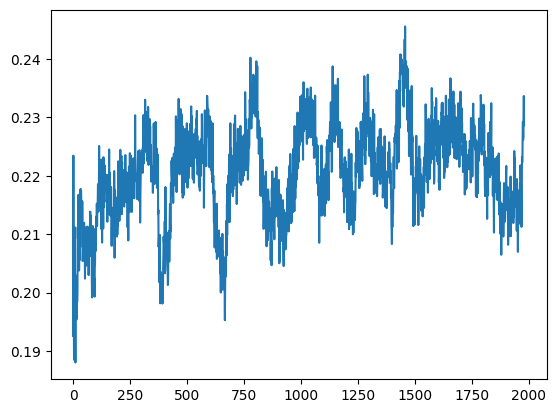

In [12]:
import matplotlib.pyplot as plt
plt.plot(aaa)

[-161. -190. -132. ... -201. -168. -179.]


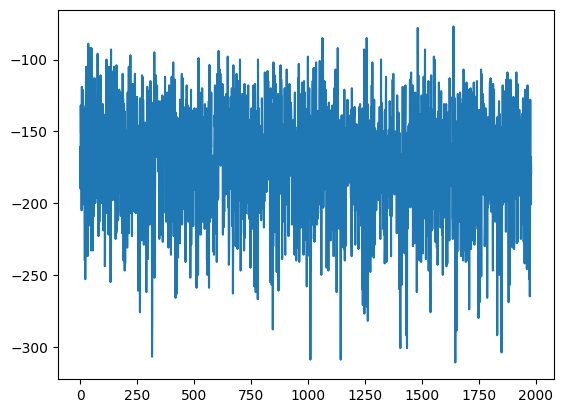

In [14]:
import matplotlib.pyplot as plt

bbb = np.load("dqn_training_rewards_Jul22_Single_Turbo.npy")
print(bbb)
plt.plot(bbb)

In [ ]:
S = 9
H = 16
i = 1
l = 1 + (3*S + 2*H)*i + 4*8
print(l)

In [ ]:
S = 9
H = 16
i = 3
l = 1 + (3*S + 2*H)*i + 4*8
print(l)